# CSPB 3022 Project: Location, Location, Location
##### by Patrick Chesnut

## Introduction

Location, location, location is a common refrain among real estate agents.  The mantra conveys that when valuing a property, location is of utmost importance.  But how true is this?  Is location really a good predictor of home value?  I will attempt to find out using a dataset of home prices in Taipei.  The dataset comes from the UC Irvine Machine Learning Repository and can be accessed [here](https://archive-beta.ics.uci.edu/ml/datasets/real+estate+valuation+data+set).  It consists of six explanatory variables and one response variable.  More details on the dataset are given below in the Data section, but this project is a regression problem not a classification problem.  The reponse varible is a measure of home price and is a continuous variable.  The goal of the analysis will be to predict home value given an arbitrary set of explanatory variables all dealing with location.  If the model is able to successfully predict the value of homes, it lends credence to the location, location, location mantra.  If the model performs poorly, it may indicate that other factors besides location influence home value.

## General Dataset Description

The dataset contains 414 observations (rows) and is present in one single table.  There is an index in the first column and 6 other columns containing features (explanatory variables).  Below is a brief description of the features.
- Transaction date: Month and year that property was sold, e.g. 2012.917 = November 2012 (continuous numeric variable)
- House age: Age of the property in years (continuous numeric variable)
- Distance to nearest MRT station: Property distance to the nearest metro station in meters (continuous numeric variable)
- Number of convience stores: The number of convenience stores within walking distance (discrete numeric variable)
- Latitude: Latitude of the property (continuous numeric variable)
- Longitude: Longitude of the property (continuous numberic variable)

The target (response variable) is home price per 3.3 meters squared (aka 1 Ping squared).  The price is measured in 10,000 New Taiwan Dollars.  For example, 37.9 indicates the sale price was <span>$</span>37,900 per square Ping.

There are two features that do not directly relate to location: transaction date and house age.  As mentioned in the Project Guide, time series analysis is outside the scope of this course.  The transaction dates range from August 2012 to July 2013.  I think it is safe to assume that home prices did not change noticably over this short period of time.  The house age could prove to be a valuable variable.  I will create an initial model that includes house age.  When going through the parameter selection process, if house age is found to not be signifcant and not improve predictive value it will lend credence to the location, location, location adage.

The dataset contains no null or missing values.

In [106]:
# Loading standard libraries and settings
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy
import scipy.stats as stats
import math
import seaborn as sns
# Set color map to have light blue background
sns.set()
import statsmodels.formula.api as smf
import statsmodels.api as sm

In [107]:
# Reading in the data
df = pd.read_csv('./Real_estate_valuation_data_set.csv')

## Data Cleaning and Exploratory Data Analysis

As mentioned above there are no missing values, however, there may be outliers that sould be dealt with.  Below is a boxplot of the home prices.  There are two observations that are more than 1.5 times the interquartile range.  I decided to look at these homes using Google street view by entering the longitude and lattitude coordinates.  It looks like they may be single family detached homes.  If they are, it seems reasonable that their prices would be higher than the vast majority of homes given the density of Taipei.  I don't see a reason to throw them out.  I don't think they are in error and given the dataset includes 414 homes, I don't expect them to skew the results in any meaningful way.

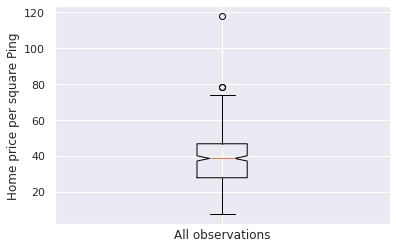

In [108]:
plt.boxplot(df['Y house price of unit area'], notch=True)
plt.ylabel('Home price per square Ping')
plt.xlabel('All observations')
plt.tick_params(axis='x',which='both',bottom=False,top=False,labelbottom=False)

I next wanted to look at the distribution of home prices.  Below is a histogram of home prices per square Ping with a normal distribution overlayed on top.  As can be seen, the data is somewhat normal, but definitely skewed to the right.  It seems to follow the normal phenomena of income and wealth being skewed to the right.

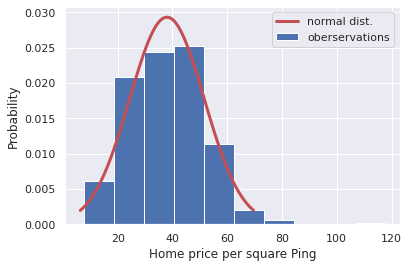

In [109]:
# Calc the mean and SD
home_mean = df['Y house price of unit area'].mean()
home_sd = df['Y house price of unit area'].std()

# Create frozen distribution
home_rv = stats.norm(loc=home_mean, scale=home_sd)
plt.hist(df['Y house price of unit area'], density=True, label='oberservations')

# Plot
fr_x = np.linspace(home_rv.ppf(0.01), home_rv.ppf(0.99), 100)
plt.plot(fr_x, home_rv.pdf(fr_x), 'r-', lw=3, label='normal dist.');
plt.ylabel('Probability')
plt.xlabel('Home price per square Ping')
plt.legend(loc='upper right');

I now want to focus on variables dealing with location.  Below is a scatter plot of the longitude and latitude coordinates.  This gives a general idea of how the homes are distributed geographically.  I was able to overlay the home locations on Google Maps.  It can be viewed [here](https://www.google.com/maps/d/u/0/edit?mid=1WFaA57FKib_SXP3e6H-s_YJSyi0L_Xpe&usp=sharing).  You can see how there is one large cluster of homes in a city center (Xindian district) and then there are homes situated sparsely in the surrounding areas.  Directly to the east and southeast of the Xindian district lies a cluster of homes around Jinwen University of Science and Technology.

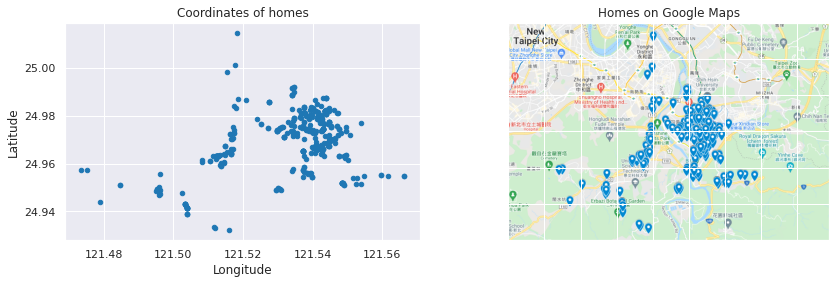

In [110]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharey=False)
axes[0].plot(df['X6 longitude'], df['X5 latitude'], linestyle='None', marker='o', color='tab:blue', ms=4.5)
axes[0].set_ylabel('Latitude')
axes[0].set_xlabel('Longitude')
axes[0].set_title('Coordinates of homes')

im = plt.imread('./map.PNG')
axes[1].imshow(im);
axes[1].tick_params(axis='x', bottom=False, labelbottom=False)
axes[1].tick_params(axis='y', left=False, labelleft=False)
axes[1].set_title('Homes on Google Maps');

I thought it would be interesting to divide the homes up into three sectors, Xindian district, University district, and Outskirts, to see if certain areas of the city have higher home prices than others.  In this way, the longitudes and latitudes can be converted from numerical variables to categorical variables.

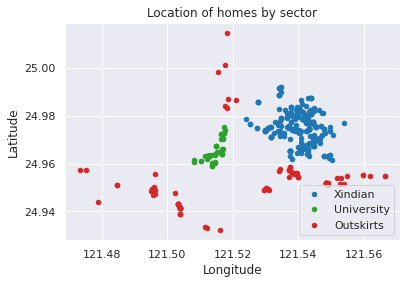

In [111]:
# Function to divy up the homes into 3 sectors
def home_sectors(longitude, latitude):
    if (longitude >= 121.522 and longitude <= 121.56) and (latitude >= 24.96 and latitude < 25):
        return 'Xindian'
    elif (longitude >= 121.505 and longitude <= 121.52) and (latitude >= 24.95 and latitude < 24.979):
        return 'University'
    else:
        return 'Outskirts'

# Apply the function to longs and lats and create new feature variable
df['Sector'] = df.apply(lambda x: home_sectors(x['X6 longitude'], x['X5 latitude']), axis=1)

# New graph with color coded homes
plt.plot(df[df.Sector == 'Xindian']['X6 longitude'], df[df.Sector == 'Xindian']['X5 latitude'],
         linestyle='None', marker='o', color='tab:blue', ms=4.5, label='Xindian')
plt.plot(df[df.Sector == 'University']['X6 longitude'], df[df.Sector == 'University']['X5 latitude'],
         linestyle='None', marker='o', color='tab:green', ms=4.5, label='University')
plt.plot(df[df.Sector == 'Outskirts']['X6 longitude'], df[df.Sector == 'Outskirts']['X5 latitude'],
         linestyle='None', marker='o', color='tab:red', ms=4.5, label='Outskirts')
plt.ylabel('Latitude')
plt.xlabel('Longitude')
plt.legend(loc='lower right')
plt.title('Location of homes by sector');


To get a sense of how home values vary by sector, I decided to calculate the means and 95% confidence intervals for each sector using the t distribution.  The mean price in the Xindian sector is quite a bit higher than the University sector and the Outskirts sector.  The 95% confidence intervals for the University and Outskirts overlap, so the mean values are not significantly different.

| Sector | $c_l$ | $\bar x_n$ | $c_u$ | Observations |
| :------:|:-----:|:----------:|:----:| :------: |
| Xindian | 43.6813 | 44.1187  | 44.5561  | 273 |
| University | 26.0045 | 26.3577 | 26.7109 | 52 |
| Outskirts | 25.1239 | 25.9416 | 26.7592 | 89 |
| All | 37.5432 | 37.9802 | 38.3589| 414 |


In [112]:
xindian_mean = df[df.Sector == 'Xindian']['Y house price of unit area'].mean()
xindian_sd = df[df.Sector == 'Xindian']['Y house price of unit area'].std()
university_mean = df[df.Sector == 'University']['Y house price of unit area'].mean()
university_sd = df[df.Sector == 'University']['Y house price of unit area'].std()
outskirts_mean = df[df.Sector == 'Outskirts']['Y house price of unit area'].mean()
outskirts_sd = df[df.Sector == 'Outskirts']['Y house price of unit area'].std()
all_mean = df['Y house price of unit area'].mean()
all_sd = df['Y house price of unit area'].std()

c1 = stats.t(df[df.Sector == 'Xindian'].size - 1).ppf((1-0.95)/2)
c2 = stats.t(df[df.Sector == 'Xindian'].size - 1).ppf(1-(1-0.95)/2)
print('Xindian mean: ' + str(xindian_mean))
print('Xindian 95% CI: ' + str(xindian_mean + c1*(xindian_sd/np.sqrt(df[df.Sector == 'Xindian'].size))) + ', ' +
      str(xindian_mean + c2*(xindian_sd/np.sqrt(df[df.Sector == 'Xindian'].size))))
print('Xindian observations: ' + str(df[df.Sector == 'Xindian']['Y house price of unit area'].size))

c1 = stats.t(df[df.Sector == 'University'].size - 1).ppf((1-0.95)/2)
c2 = stats.t(df[df.Sector == 'University'].size - 1).ppf(1-(1-0.95)/2)
print('University mean: ' + str(university_mean))
print('University 95% CI: ' + str(university_mean + c1*(university_sd/np.sqrt(df[df.Sector == 'University'].size))) + ', ' +
      str(university_mean + c2*(university_sd/np.sqrt(df[df.Sector == 'University'].size))))
print('University observations: ' + str(df[df.Sector == 'University']['Y house price of unit area'].size))

c1 = stats.t(df[df.Sector == 'Outskirts'].size - 1).ppf((1-0.95)/2)
c2 = stats.t(df[df.Sector == 'Outskirts'].size - 1).ppf(1-(1-0.95)/2)
print('Outskirts mean: ' + str(outskirts_mean))
print('Outskirts 95% CI: ' + str(outskirts_mean + c1*(outskirts_sd/np.sqrt(df[df.Sector == 'Outskirts'].size))) + ', ' +
      str(outskirts_mean + c2*(outskirts_sd/np.sqrt(df[df.Sector == 'Outskirts'].size))))
print('Outskirts observations: ' + str(df[df.Sector == 'Outskirts']['Y house price of unit area'].size))

c1 = stats.t(df.size - 1).ppf((1-0.95)/2)
c2 = stats.t(df.size - 1).ppf(1-(1-0.95)/2)
print('All mean: ' + str(all_mean))
print('All 95% CI: ' + str(all_mean + c1*(all_sd/np.sqrt(df.size))) + ', ' +
      str(all_mean + c2*(outskirts_sd/np.sqrt(df.size))))
print('All observations: ' + str(df['Y house price of unit area'].size))


Xindian mean: 44.11868131868132
Xindian 95% CI: 43.68128988028574, 44.5560727570769
Xindian observations: 273
University mean: 26.357692307692307
University 95% CI: 26.004457243802822, 26.710927371581793
University observations: 52
Outskirts mean: 25.94157303370787
Outskirts 95% CI: 25.123921401043155, 26.75922466637258
Outskirts observations: 89
All mean: 37.98019323671498
All 95% CI: 37.54316063404944, 38.35885088199574
All observations: 414


To explore location further, I think it would be interesting to plot longitude and latitude versus home values.  To me it looks like there is a slight positive correlation between home price and both longitude and latitude.  This seems to follow from the fact that homes in the Xindian district in the northeast of the city are the most valuable on a per Ping basis.

Correlation coefficient between longitude and home price: 0.5232865070287566
Correlation coefficient between latitude and home price: 0.5463066525036047


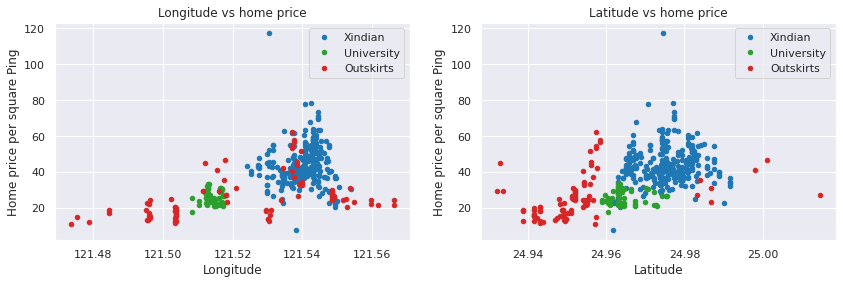

In [113]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharey=False)
axes[0].plot(df[df.Sector == 'Xindian']['X6 longitude'], df[df.Sector == 'Xindian']['Y house price of unit area'],
         linestyle='None', marker='o', color='tab:blue', ms=4.5, label='Xindian')
axes[0].plot(df[df.Sector == 'University']['X6 longitude'], df[df.Sector == 'University']['Y house price of unit area'],
         linestyle='None', marker='o', color='tab:green', ms=4.5, label='University')
axes[0].plot(df[df.Sector == 'Outskirts']['X6 longitude'], df[df.Sector == 'Outskirts']['Y house price of unit area'],
         linestyle='None', marker='o', color='tab:red', ms=4.5, label='Outskirts')
axes[0].set_ylabel('Home price per square Ping')
axes[0].set_xlabel('Longitude')
axes[0].set_title('Longitude vs home price')
axes[0].legend(loc='upper right')

axes[1].plot(df[df.Sector == 'Xindian']['X5 latitude'], df[df.Sector == 'Xindian']['Y house price of unit area'],
         linestyle='None', marker='o', color='tab:blue', ms=4.5, label='Xindian')
axes[1].plot(df[df.Sector == 'University']['X5 latitude'], df[df.Sector == 'University']['Y house price of unit area'],
         linestyle='None', marker='o', color='tab:green', ms=4.5, label='University')
axes[1].plot(df[df.Sector == 'Outskirts']['X5 latitude'], df[df.Sector == 'Outskirts']['Y house price of unit area'],
         linestyle='None', marker='o', color='tab:red', ms=4.5, label='Outskirts')
axes[1].set_ylabel('Home price per square Ping')
axes[1].set_xlabel('Latitude')
axes[1].set_title('Latitude vs home price')
axes[1].legend(loc='upper right')

corLong = df['X6 longitude'].corr(df['Y house price of unit area'])
corLat = df['X5 latitude'].corr(df['Y house price of unit area'])
print('Correlation coefficient between longitude and home price: ' + str(corLong))
print('Correlation coefficient between latitude and home price: ' + str(corLat))

Next, I want to explore location amenities (metro stations, convenience stores) and home prices.  The graphs and correlation coefficients below show that homes are more valuable the closer they are to metro stations and also more valuable when they have multiple convience stores within walking distance. Here again, we see that the Xindian district has the closest metro stations and most convenience stores within walking distance.

Correlation coefficient between metro stations and home price: -0.6736128553689185
Correlation coefficient between convenience stores and home price: 0.5710049111111483


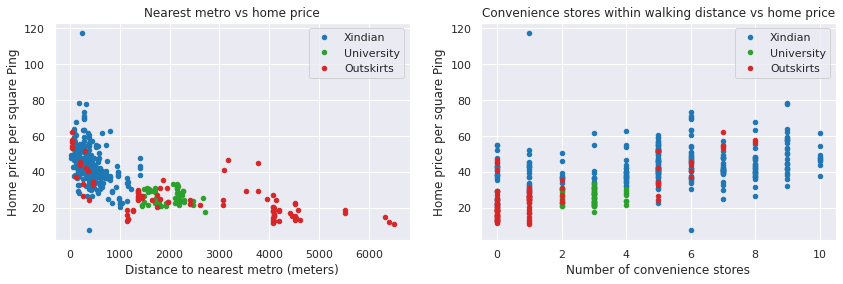

In [114]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,4), sharey=False)
axes[0].plot(df[df.Sector == 'Xindian']['X3 distance to the nearest MRT station'], df[df.Sector == 'Xindian']['Y house price of unit area'],
         linestyle='None', marker='o', color='tab:blue', ms=4.5, label='Xindian')
axes[0].plot(df[df.Sector == 'University']['X3 distance to the nearest MRT station'], df[df.Sector == 'University']['Y house price of unit area'],
         linestyle='None', marker='o', color='tab:green', ms=4.5, label='University')
axes[0].plot(df[df.Sector == 'Outskirts']['X3 distance to the nearest MRT station'], df[df.Sector == 'Outskirts']['Y house price of unit area'],
         linestyle='None', marker='o', color='tab:red', ms=4.5, label='Outskirts')
axes[0].set_ylabel('Home price per square Ping')
axes[0].set_xlabel('Distance to nearest metro (meters)')
axes[0].set_title('Nearest metro vs home price')
axes[0].legend(loc='upper right')

axes[1].plot(df[df.Sector == 'Xindian']['X4 number of convenience stores'], df[df.Sector == 'Xindian']['Y house price of unit area'],
         linestyle='None', marker='o', color='tab:blue', ms=4.5, label='Xindian')
axes[1].plot(df[df.Sector == 'University']['X4 number of convenience stores'], df[df.Sector == 'University']['Y house price of unit area'],
         linestyle='None', marker='o', color='tab:green', ms=4.5, label='University')
axes[1].plot(df[df.Sector == 'Outskirts']['X4 number of convenience stores'], df[df.Sector == 'Outskirts']['Y house price of unit area'],
         linestyle='None', marker='o', color='tab:red', ms=4.5, label='Outskirts')
axes[1].set_ylabel('Home price per square Ping')
axes[1].set_xlabel('Number of convenience stores')
axes[1].set_title('Convenience stores within walking distance vs home price')
axes[1].legend(loc='upper right');

corMetro = df['X3 distance to the nearest MRT station'].corr(df['Y house price of unit area'])
corConv = df['X4 number of convenience stores'].corr(df['Y house price of unit area'])
print('Correlation coefficient between metro stations and home price: ' + str(corMetro))
print('Correlation coefficient between convenience stores and home price: ' + str(corConv))

Looking at the graphs above, it seems likely that distance to nearest metro station and number of convenience stores within walking distance are correlated.  I think this because the Xindian homes seem to be close to metros and also have a high number of convenience stores.  This does seem to be born out in the calculation below.  I think it will be important to include an interation term in my regression model to see if nearness to metro stations and convenience stores have a synergy effect on home values.

In [115]:
corMetroConv = df['X3 distance to the nearest MRT station'].corr(df['X4 number of convenience stores'])
print('Correlation coefficient between metro stations and convenience stores: ' + str(corMetroConv))

Correlation coefficient between metro stations and convenience stores: -0.6025191447226248


Finally, I want to examine the one variable that does not involve location, house age.  Here we can see that newer homes tend to be slightly more valable than older homes.  Looking at the scatterplot though, it appears that homes that are exceptionally old (>35 years) appear to regain some of their value.  It looks to me like home ages are fairly well distributed among the three sectors, though the Xindian district does have the oldest homes.

Given that the correlation coefficient is not exactly zero, I expect that adding home age to the model will at least marginally improve the model and may substantially improve it.

Correlation coefficient between home age and home price: -0.21056704627721692


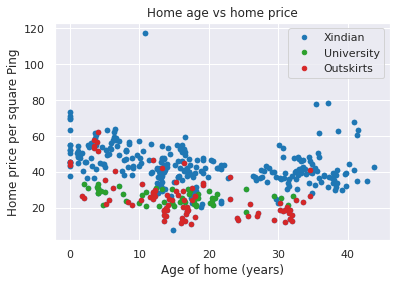

In [116]:
plt.plot(df['X2 house age'], df['Y house price of unit area'], linestyle='None', marker='o', color='tab:blue', ms=4.5)
plt.plot(df[df.Sector == 'Xindian']['X2 house age'], df[df.Sector == 'Xindian']['Y house price of unit area'],
         linestyle='None', marker='o', color='tab:blue', ms=4.5, label='Xindian')
plt.plot(df[df.Sector == 'University']['X2 house age'], df[df.Sector == 'University']['Y house price of unit area'],
         linestyle='None', marker='o', color='tab:green', ms=4.5, label='University')
plt.plot(df[df.Sector == 'Outskirts']['X2 house age'], df[df.Sector == 'Outskirts']['Y house price of unit area'],
         linestyle='None', marker='o', color='tab:red', ms=4.5, label='Outskirts')
plt.legend(loc='upper right')
plt.ylabel('Home price per square Ping')
plt.xlabel('Age of home (years)')
plt.title('Home age vs home price')
corAge = df['X2 house age'].corr(df['Y house price of unit area'])
print('Correlation coefficient between home age and home price: ' + str(corAge))

The EDA section started by looking for outliers in the dataset.  Two homes had exceptionally high prices per Ping, but are most like detached houses so this was expected.  Next, the home prices were shown to be somewhat normally distributed, but skewed to the right.  This is a common feature of economic data.  Given that the data was skewed sligtly, the t distribution was used to determine if mean home prices vary significantly between the three different sectors I identified.  The 95% confidence intervals suggest that the Xindian district is significantly more expensive than the University and Outskirts sectors.  It shown next that both longitude and latitude are positively correlated with home price.  This is most likely an artifact of the Xindian district being in the northeast part of the dataset.  I suspect that longitude and latitude will not improve the model much since location data was already parsed into the sector variable.  Focus was then turned to data on nearest metro station and number of convenience stores within walking distance.  Nearest metro station appears to be non-linearly and negatively corrollated with home price, and number of metro stations linearly and positively corrolated with home price.  I mentioned that there could be interaction between these two variables because they have a correlation coefficient of -0.6025.  I will want to include a interaction variable in my model to account for this.  Finally, home age and price was shown to be slightly negatively corrolated and possibly non-linear.  Model formulation should see whether a linear or non-linear treatment has more predictive value.

## Model Approach

The exploratory data analysis performed above has given me some good ideas on how to tackle the model.  It appears to me that nearness to a metro station and home age may not have linear relationships with home price.  I plan on running both linear and non-linear regressions for these variables to see which gives a better R-square score.  Which ever type of model comes out on top will be incorporated into a larger model with the other variables.

As I mentioned above, nearness to metro stations and number of convenience stores within walking distance appear to be highly correlated.  As such, I propose creating a new data column that multiplies these two variables to test for interaction.  I suspect that adding an interaction variable to the model will improve the R-square as homes that are both near to a metro station and have a number of convenience stores nearby may be more valuable than either variable alone would predict.

I plan on creating two dummy variables to track the effect home sector has on price.  The data has been divided up into three sectors: Xindian, University and Outskirts.  Since Outskirts had the lowest average price, I will make that the baseline scenario for my model.  Since Outskirts is my baseline, I will have one dummy variable for University and one for Xindian.  

At this point I plan on selecting final model parameters using the backward stepwise process.  I will start with all parameters in the model and then iteratively remove the parameter with the highest p-value until all p-values are significant at the 0.05 level.


## Models

#### Variable generation and testing for non-linearity

As mentioned above, new features (columns) need to be generated to perform a more complex analysis.  The code below first creates an interaction variable for number of convenience stores and distance to the nearest MRT station.  It then creates two dummy variables for the Xindian district and the University district, making outskirts the basecase.

In [117]:
# Create interaction term for metro stations and convenience stores
df['metroxconv'] = df['X3 distance to the nearest MRT station'] * df['X4 number of convenience stores']

# Create dummy variables for University and Xindian sectors
def getXindian(sector_name):
    if (sector_name == 'Xindian'):
        return 1
    else:
        return 0

def getUniversity(sector_name):
    if (sector_name == 'University'):
        return 1
    else:
        return 0

df['Xindian'] = df.apply(lambda x: getXindian(x['Sector']), axis = 1)
df['University'] = df.apply(lambda x: getUniversity(x['Sector']), axis = 1)

# Renaming columns to remove spaces
df = df.rename(columns={"X1 transaction date":"transaction_date","X2 house age":"house_age","X3 distance to the nearest MRT station":
                   "MRT_station","X4 number of convenience stores":"conv_stores",
                   "X5 latitude":"latitude","X6 longitude":"longitude","Y house price of unit area":"house_price"})

df.head()

,No,transaction_date,house_age,MRT_station,conv_stores,latitude,longitude,house_price,Sector,metroxconv,Xindian,University
0,1,2012.917,32.0,84.87882,10,24.98298,121.54024,37.9,Xindian,848.7882,1,0
1,2,2012.917,19.5,306.59470,9,24.98034,121.53951,42.2,Xindian,2759.3523,1,0
2,3,2013.583,13.3,561.98450,5,24.98746,121.54391,47.3,Xindian,2809.9225,1,0
3,4,2013.500,13.3,561.98450,5,24.98746,121.54391,54.8,Xindian,2809.9225,1,0
4,5,2012.833,5.0,390.56840,5,24.97937,121.54245,43.1,Xindian,1952.8420,1,0


I next will explore whether nearest metro station versus price and home age versus price are better modeled linearly or non-linearly.  I will start with nearest metro station.

Model is Price =  45.851427057774984 + -0.0072620516181494555 * nearest MRT station
R-squared is  0.45375427891826703
Adjusted R-squared is 0.4524284397894278


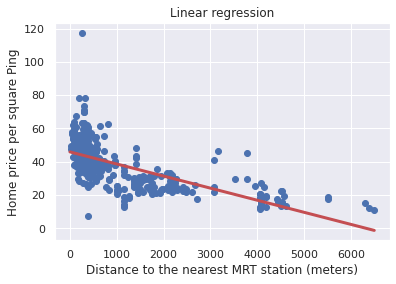

In [118]:
# House price vs metro station, linear
metro_lin_model = smf.ols(formula='house_price ~ MRT_station', data=df).fit()
beta0, beta1 = metro_lin_model.params
print('Model is Price = ', beta0, '+', beta1, '* nearest MRT station')
print('R-squared is ', metro_lin_model.rsquared)
print('Adjusted R-squared is', metro_lin_model.rsquared_adj)
xticks = np.linspace(0, 6500, 1000)
plt.plot(df['MRT_station'], df['house_price'], 'bo');
plt.xlabel('Distance to the nearest MRT station (meters)')
plt.ylabel('Home price per square Ping')
plt.title('Linear regression')
plt.plot(xticks, beta0 + beta1 * xticks, lw=3, color='r');

Model is Price =  49.78154180319846 + -0.01553404268321506 * nearest MRT station + 1.8219951058871016e-06 * nearest MRT station^2
R-squared is  0.5269753236133142
Adjusted R-squared is 0.5246735003705567


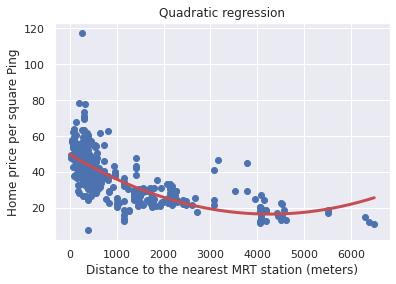

In [119]:
# House price vs metro station, quadratic
metro_quad_model = smf.ols(formula='house_price ~ MRT_station + np.power(MRT_station,2)', data=df).fit()
beta0, beta1, beta2 = metro_quad_model.params
print('Model is Price = ', beta0, '+', beta1, '* nearest MRT station', '+', beta2, '* nearest MRT station^2')
print('R-squared is ', metro_quad_model.rsquared)
print('Adjusted R-squared is', metro_quad_model.rsquared_adj)
xticks = np.linspace(0, 6500, 1000)
plt.plot(df['MRT_station'], df['house_price'], 'bo');
plt.xlabel('Distance to the nearest MRT station (meters)')
plt.ylabel('Home price per square Ping')
plt.title('Quadratic regression')
plt.plot(xticks, beta0 + beta1 * xticks + beta2 * xticks**2, lw=3, color='r');

Model is Price =  52.73448512178587 + -0.025086380130540306 * nearest MRT station + 6.765021174257882e-06 * nearest MRT station^2 + -6.13231315987226e-10 * nearest MRT station^3
R-squared is  0.5562270367493445
Adjusted R-squared is 0.552979917506047


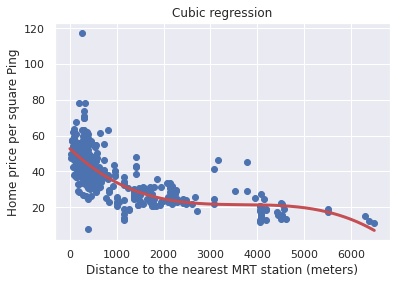

In [120]:
# House price vs. metro station, cubic
metro_cub_model = smf.ols(formula='house_price ~ MRT_station + np.power(MRT_station,2) + np.power(MRT_station,3)', data=df).fit()
beta0, beta1, beta2, beta3 = metro_cub_model.params
print('Model is Price = ', beta0, '+', beta1, '* nearest MRT station', '+', beta2, '* nearest MRT station^2', '+', beta3, '* nearest MRT station^3')
print('R-squared is ', metro_cub_model.rsquared)
print('Adjusted R-squared is', metro_cub_model.rsquared_adj)
xticks = np.linspace(0, 6500, 1000)
plt.plot(df['MRT_station'], df['house_price'], 'bo');
plt.xlabel('Distance to the nearest MRT station (meters)')
plt.ylabel('Home price per square Ping')
plt.title('Cubic regression')
plt.plot(xticks, beta0 + beta1 * xticks + beta2 * xticks**2 + beta3 * xticks**3, lw=3, color='r');

It looks to me like the cubic function does a pretty good job of drawing a line of best fit.  The R-squared increase about 0.1 over the linear regression.  I will use the cubic function when building out the rest of my model.  I will now look at home age vs price.

Model is Price =  42.43469704626289 + -0.25148841908534564 * house age
R-squared is  0.04433848097791193
Adjusted R-squared is 0.04201891418416892


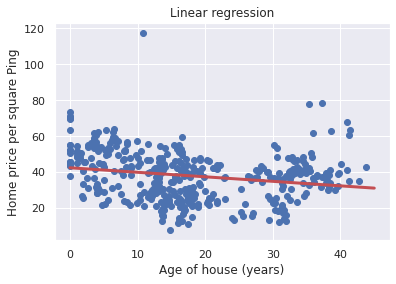

In [121]:
# House price vs. age, linear
age_lin_model = smf.ols(formula='house_price ~ house_age', data=df).fit()
beta0, beta1 = age_lin_model.params
print('Model is Price = ', beta0, '+', beta1, '* house age')
print('R-squared is ', age_lin_model.rsquared)
print('Adjusted R-squared is', age_lin_model.rsquared_adj)
xticks = np.linspace(0, 45, 300)
plt.plot(df['house_age'], df['house_price'], 'bo');
plt.xlabel('Age of house (years)')
plt.ylabel('Home price per square Ping')
plt.title('Linear regression')
plt.plot(xticks, beta0 + beta1 * xticks, lw=3, color='r');

Model is Price =  53.45053903402762 + -1.9288769512912356 * house age + 0.04218091577471245 * house age^2
R-squared is 0.2015407033380714
Adjusted R-squared is 0.19765525663898653


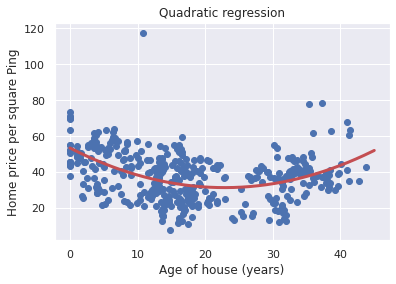

In [122]:
# House price vs. age, quadratic
age_quad_model = smf.ols(formula='house_price ~ house_age + np.power(house_age,2)', data=df).fit()
beta0, beta1, beta2 = age_quad_model.params
print('Model is Price = ', beta0, '+', beta1, '* house age', '+', beta2, '* house age^2')
print('R-squared is', age_quad_model.rsquared)
print('Adjusted R-squared is', age_quad_model.rsquared_adj)
xticks = np.linspace(0, 45, 300)
plt.plot(df['house_age'], df['house_price'], 'bo');
plt.xlabel('Age of house (years)')
plt.ylabel('Home price per square Ping')
plt.title('Quadratic regression')
plt.plot(xticks, beta0 + beta1 * xticks + beta2 * xticks**2, lw=3, color='r');

Here the quadratic model does a better job than the linear model, but it still performs relatively poorly.  Only 20% of the variation in home price can be explained by the age of the house.

#### Model Selection

I will now build out a model using the backward stepwise selection.  Briefly, I will start with a model that contains all available parameters and toss out the least significant parameter.  I will repeat this process until all parameters have a p-value of less than 0.05.  The full model with all parameters is given below.

In [123]:
# Full model with all params
full_model = smf.ols(formula='house_price ~ house_age + np.power(house_age,2) + MRT_station + \
                     np.power(MRT_station,2) + np.power(MRT_station,3) + conv_stores + latitude + longitude + \
                     metroxconv + Xindian + University', data=df).fit()
full_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            house_price   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     83.22
Date:                Tue, 03 May 2022   Prob (F-statistic):           1.44e-91
Time:                        03:26:18   Log-Likelihood:                -1435.9
No. Observations:                 414   AIC:                             2894.
Df Residuals:                     403   BIC:                             2938.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -1.233e+04   8001.970     -1.541      0.124   -2.81e+04    3396.879
house_age                   -0.9055      0.136     -6.637      0.000      -1.174      -0.637
np.power(house_age, 2)       0.0161      0.003      4.894      0.000       0.010       0.023
MRT_station                 -0.0190      0.004     -4.834      0.000      -0.027      -0.011
np.power(MRT_station, 2)  6.077e-06   1.52e-06      4.006      0.000    3.09e-06    9.06e-06
np.power(MRT_station, 3)  -5.74e-10   1.58e-10     -3.623      0.000   -8.86e-10   -2.63e-10
conv_stores                  0.5494      0.288      1.909      0.057      -0.016       1.115
latitude                   301.1429     49.304      6.108      0.000     204.217     398.069
longitude                   40.0599     62.837      0.638      0.524     -83.470     163.590
metroxconv                  -0.0003      0.000     -0.644      0.520      -0.001       0.001
Xindian                      1.1986      1.758      0.682      0.496      -2.257       4.654
University                   1.2637      2.499      0.506      0.613      -3.650       6.177
==============================================================================
Omnibus:                      283.958   Durbin-Watson:                   2.164
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7434.743
Skew:                           2.499   Prob(JB):                         0.00
Kurtosis:                      23.150   Cond. No.                     6.82e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.82e+14. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

The Univerisity variable has the highest p-value, so it will be removed first.  Our basecase can now be interpreted as any house in the outskirts or University neighborhoods.

In [124]:
# Removing University from the above model
step1_model = smf.ols(formula='house_price ~ house_age + np.power(house_age,2) + MRT_station + \
                     np.power(MRT_station,2) + np.power(MRT_station,3) + conv_stores + latitude + longitude + \
                     metroxconv + Xindian', data=df).fit()
step1_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            house_price   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     92.61
Date:                Tue, 03 May 2022   Prob (F-statistic):           1.65e-92
Time:                        03:26:19   Log-Likelihood:                -1436.0
No. Observations:                 414   AIC:                             2892.
Df Residuals:                     404   BIC:                             2932.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -1.036e+04   6983.329     -1.484      0.139   -2.41e+04    3363.802
house_age                   -0.9117      0.136     -6.716      0.000      -1.179      -0.645
np.power(house_age, 2)       0.0161      0.003      4.929      0.000       0.010       0.023
MRT_station                 -0.0187      0.004     -4.814      0.000      -0.026      -0.011
np.power(MRT_station, 2)  5.959e-06    1.5e-06      3.979      0.000    3.02e-06     8.9e-06
np.power(MRT_station, 3)  -5.69e-10   1.58e-10     -3.601      0.000    -8.8e-10   -2.58e-10
conv_stores                  0.5492      0.287      1.911      0.057      -0.016       1.114
latitude                   299.8756     49.195      6.096      0.000     203.165     396.586
longitude                   24.1160     54.301      0.444      0.657     -82.632     130.864
metroxconv                  -0.0002      0.000     -0.483      0.630      -0.001       0.001
Xindian                      0.9769      1.700      0.575      0.566      -2.366       4.320
==============================================================================
Omnibus:                      283.402   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7406.149
Skew:                           2.493   Prob(JB):                         0.00
Kurtosis:                      23.112   Cond. No.                     5.96e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.96e+14. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

After removing University, we do not see any increase in either R-squared or adjusted R-squared.  Longitude now has the highest p-value and will be removed next.

In [125]:
# Removing longitude from the above model
step2_model = smf.ols(formula='house_price ~ house_age + np.power(house_age,2) + MRT_station + \
                     np.power(MRT_station,2) + np.power(MRT_station,3) + conv_stores + latitude + \
                     metroxconv + Xindian', data=df).fit()
step2_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            house_price   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     92.55
Date:                Tue, 03 May 2022   Prob (F-statistic):           1.82e-92
Time:                        03:26:19   Log-Likelihood:                -1436.1
No. Observations:                 414   AIC:                             2892.
Df Residuals:                     404   BIC:                             2932.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -7308.7236   1194.986     -6.116      0.000   -9657.890   -4959.557
house_age                   -0.9157      0.135     -6.758      0.000      -1.182      -0.649
np.power(house_age, 2)       0.0162      0.003      4.945      0.000       0.010       0.023
MRT_station                 -0.0179      0.003     -5.162      0.000      -0.025      -0.011
np.power(MRT_station, 2)  5.617e-06   1.28e-06      4.372      0.000    3.09e-06    8.14e-06
np.power(MRT_station, 3) -5.362e-10    1.4e-10     -3.837      0.000   -8.11e-10   -2.62e-10
conv_stores                  0.6064      0.257      2.360      0.019       0.101       1.112
latitude                   294.8642     47.895      6.156      0.000     200.709     389.019
metroxconv                  -0.0003      0.000     -0.873      0.383      -0.001       0.000
Xindian                      1.2013      1.624      0.740      0.460      -1.991       4.394
==============================================================================
Omnibus:                      282.109   Durbin-Watson:                   2.162
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7319.379
Skew:                           2.478   Prob(JB):                         0.00
Kurtosis:                      22.994   Cond. No.                     1.02e+14
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+14. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

After removing Longitude, R-squared dropped slightly, but adjusted R-squared remained the same.  Xindian now has the highest p-value and will be removed next.

In [126]:
# Removing Xindian from the above model
step3_model = smf.ols(formula='house_price ~ house_age + np.power(house_age,2) + MRT_station + \
                     np.power(MRT_station,2) + np.power(MRT_station,3) + conv_stores + latitude + \
                     metroxconv', data=df).fit()
step3_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            house_price   R-squared:                       0.673
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     104.2
Date:                Tue, 03 May 2022   Prob (F-statistic):           2.26e-93
Time:                        03:26:19   Log-Likelihood:                -1436.4
No. Observations:                 414   AIC:                             2891.
Df Residuals:                     405   BIC:                             2927.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -7778.0874   1012.010     -7.686      0.000   -9767.536   -5788.638
house_age                   -0.9039      0.134     -6.721      0.000      -1.168      -0.640
np.power(house_age, 2)       0.0160      0.003      4.904      0.000       0.010       0.022
MRT_station                 -0.0188      0.003     -5.752      0.000      -0.025      -0.012
np.power(MRT_station, 2)  5.811e-06   1.26e-06      4.623      0.000    3.34e-06    8.28e-06
np.power(MRT_station, 3) -5.486e-10   1.39e-10     -3.957      0.000   -8.21e-10   -2.76e-10
conv_stores                  0.5871      0.256      2.298      0.022       0.085       1.089
latitude                   313.7148     40.529      7.740      0.000     234.041     393.388
metroxconv                  -0.0003      0.000     -0.928      0.354      -0.001       0.000
==============================================================================
Omnibus:                      281.828   Durbin-Watson:                   2.150
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             7246.791
Skew:                           2.478   Prob(JB):                         0.00
Kurtosis:                      22.888   Cond. No.                     8.64e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.64e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

After removing Xindian from the model, R-squared and adjusted R-squared remained the same.  The interaction variable between distance to nearest metro stations and number of convenience stores is now the least significant and will be removed next.

In [127]:
# Removing metroxconv from the above model
step4_model = smf.ols(formula='house_price ~ house_age + np.power(house_age,2) + MRT_station + \
                     np.power(MRT_station,2) + np.power(MRT_station,3) + conv_stores + latitude', data=df).fit()
step4_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            house_price   R-squared:                       0.672
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                     119.0
Date:                Tue, 03 May 2022   Prob (F-statistic):           3.06e-94
Time:                        03:26:19   Log-Likelihood:                -1436.8
No. Observations:                 414   AIC:                             2890.
Df Residuals:                     406   BIC:                             2922.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -7657.3478   1003.442     -7.631      0.000   -9629.937   -5684.758
house_age                   -0.8950      0.134     -6.673      0.000      -1.159      -0.631
np.power(house_age, 2)       0.0158      0.003      4.860      0.000       0.009       0.022
MRT_station                 -0.0211      0.002    -10.102      0.000      -0.025      -0.017
np.power(MRT_station, 2)  6.622e-06   9.04e-07      7.326      0.000    4.84e-06     8.4e-06
np.power(MRT_station, 3) -6.303e-10   1.07e-10     -5.888      0.000   -8.41e-10    -4.2e-10
conv_stores                  0.4212      0.183      2.307      0.022       0.062       0.780
latitude                   308.9211     40.192      7.686      0.000     229.911     387.931
==============================================================================
Omnibus:                      278.354   Durbin-Watson:                   2.146
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6929.809
Skew:                           2.444   Prob(JB):                         0.00
Kurtosis:                      22.438   Cond. No.                     8.57e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.57e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

All remaining parameters are significant at the 0.05 level.  The model has an R-square of 0.672 and an adjusted R-squared of 0.667.  The final model can be written as $$Price = -7657.3 - 0.8950 \times HouseAge + 0.0158 \times HouseAge^2 - 0.0211 \times MRTStation + 6.622 \cdot 10^{-.06} \times MRTStation^2 - 6.303 \cdot 10^{-10} \times MRTStation^3 + 0.4212 \times ConvenienceStores + 308.9 \times Latitude$$
I next want to graph leverage versus normalized residuals squared to see if R-squared could be improved by dropping outlier values.

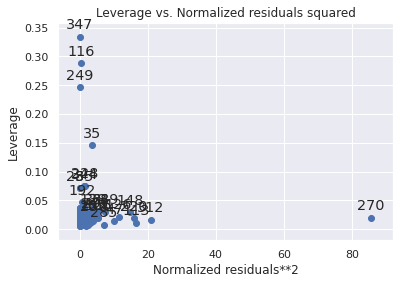

In [128]:
sm.graphics.plot_leverage_resid2(step4_model, alpha=0.05);

Here we can see that there are three values with low residuals, but high leverage, and one value with high residuals and low leverage.  I decided to drop indexes 347, 116, 249, and 270 from the data set and rerun the model above to see how r-squared is affected.

In [129]:
# Removing high residual and high leverage values
step5_model = smf.ols(formula='house_price ~ house_age + np.power(house_age,2) + MRT_station + \
                     np.power(MRT_station,2) + np.power(MRT_station,3) + conv_stores + latitude', data=df.drop([347,116,249,270])).fit()
step5_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            house_price   R-squared:                       0.711
Model:                            OLS   Adj. R-squared:                  0.706
Method:                 Least Squares   F-statistic:                     141.3
Date:                Tue, 03 May 2022   Prob (F-statistic):          3.14e-104
Time:                        03:26:19   Log-Likelihood:                -1375.7
No. Observations:                 410   AIC:                             2767.
Df Residuals:                     402   BIC:                             2800.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -7486.6998    897.877     -8.338      0.000   -9251.822   -5721.578
house_age                   -0.9246      0.120     -7.706      0.000      -1.160      -0.689
np.power(house_age, 2)       0.0169      0.003      5.802      0.000       0.011       0.023
MRT_station                 -0.0209      0.002     -8.806      0.000      -0.026      -0.016
np.power(MRT_station, 2)  7.078e-06   1.26e-06      5.637      0.000    4.61e-06    9.55e-06
np.power(MRT_station, 3) -7.363e-10   1.79e-10     -4.105      0.000   -1.09e-09   -3.84e-10
conv_stores                  0.5901      0.165      3.569      0.000       0.265       0.915
latitude                   302.0345     35.965      8.398      0.000     231.332     372.736
==============================================================================
Omnibus:                       82.334   Durbin-Watson:                   2.016
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              351.092
Skew:                           0.803   Prob(JB):                     5.77e-77
Kurtosis:                       7.240   Cond. No.                     6.33e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.33e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Now the model is showing r-squared of 0.711 and adjusted r-squared of 0.706 which is an improvement of about 0.04.  I next thought it would be interesting to try out a regression model not covered in class. This semester we covered ordinary least squares which tries to minimize the square errors.  An alternative approach is least absolute deviation.  This is a similar approach that minimizes the absolute differences in errors instead of the squares.

In [135]:
# Least absolute difference model
step6_model = smf.quantreg(formula='house_price ~ house_age + np.power(house_age,2) + MRT_station + np.power(MRT_station,2) +\
                    conv_stores + latitude', data=df.drop([347,116,249,270])).fit(q=0.5,max_iter=100000)
step6_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:            house_price   Pseudo R-squared:               0.4879
Model:                       QuantReg   Bandwidth:                       3.935
Method:                 Least Squares   Sparsity:                        14.63
Date:                Tue, 03 May 2022   No. Observations:                  410
Time:                        03:52:47   Df Residuals:                      403
                                        Df Model:                            6
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0841      0.002     34.778      0.000       0.079       0.089
house_age                   -0.6846      0.124     -5.510      0.000      -0.929      -0.440
np.power(house_age, 2)       0.0095      0.003      3.146      0.002       0.004       0.015
MRT_station                 -0.0141      0.001    -11.686      0.000      -0.016      -0.012
np.power(MRT_station, 2)  1.867e-06    2.5e-07      7.478      0.000    1.38e-06    2.36e-06
conv_stores                  0.7076      0.166      4.255      0.000       0.381       1.034
latitude                     2.0984      0.060     34.793      0.000       1.980       2.217
============================================================================================

The condition number is large, 1.46e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

For reasons unknown to me, it was not possible to run the least absolute deviation model in the statsmodel package with the cubic function for MRT stations.  After removing the higher order term, the model gives a Pseudo R-squared of 0.4879 which is much less that the R-squares produced using ordinary least squares.

#### Results and Analysis

The above section starts out by creating a new interaction variable between distance to the nearest metro station and number of convenience stores within walking distance.  It was shown earlier during exploratory data analysis that these two variables had a correlation coefficient of -0.6.  Since they are fairly well correlated, they could act synergistically to have an outsized impact on home price.

Next, dummy variables were created for the Xindian and University districts.  They were chosen because houses in the "outskirts" were shown to have the lowest average price per square foot.  The model, therefore, leaves the price of homes on the outskirts as the basecase.  The coefficients for Xindian and University districts would indicate how much more a home in the Xindian and University districts cost all else being equal.

Then it was determined that price and house age and price and distance to nearest metrostation were best modeled non-linearly.  Price and house age will be modeled quadratically while price and distance to nearest metro station will be modeled cubically.  Using high order terms raised r-squared scores significantly over first-order terms.

Finally, the process of parameter selection could begin.  I chose to use the backward stepwise strategy.  Using this strategy, the model starts out with all parameters possible in the model.  The parameter with the highest p-value is then dropped.  This process repeats itself until all remaining parameters have p-values less than 0.05.  Below is a table summarizing the process.

| Step | Description | $R^2$ | $Adjusted R^2$ | 
| :---:  | :-----:|:-----:|:----:|
| 0 | Full model | 0.674 | 0.666 |
| 1 | Drop University  | 0.674 | 0.666 |
| 2 | Drop Longitude| 0.673 | 0.666 |
| 3 | Drop Xindian | 0.673 | 0.666 |
| 4 | Drop Metro distance/convenience store interation | 0.672 | 0.667 |

As can be seen, the adjusted R-squared only improves by 0.001 and the R-squared only decreases by 0.002.  This indicates to me that variables that were dropped did not have much of an affect on the model.

I next decided to look at observations with high leverage and high residuals.  I identified four observations and decided to re-run the model with the observations dropped.  This resulted in the r-squared increasing to 0.711 and adjusted R-squared increasing to 0.706.

Finally, I decided to try to perform the regression using least absolute deviation instead of ordinary least squares.  This produced a model with a significantly worse pseudo R-squared of 0.4879.



#### Discussion and Conclusion

My final model was able to explain 66.7% of the variation in house prices in Taipei.  The factors that appear to explain prices are house age, distance to nearest metro station, and number of convenience stores within walking distance.  To get a sense of how much house prices can be explained by location, I decided to re-run an anlysis with house age removed.

In [131]:
# Removing house age from model
extra_model = smf.ols(formula='house_price ~ MRT_station + \
                     np.power(MRT_station,2) + np.power(MRT_station,3) + conv_stores + latitude', data=df).fit()
extra_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            house_price   R-squared:                       0.605
Model:                            OLS   Adj. R-squared:                  0.600
Method:                 Least Squares   F-statistic:                     125.0
Date:                Tue, 03 May 2022   Prob (F-statistic):           5.29e-80
Time:                        03:26:27   Log-Likelihood:                -1475.4
No. Observations:                 414   AIC:                             2963.
Df Residuals:                     408   BIC:                             2987.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                -7091.8640   1096.719     -6.466      0.000   -9247.789   -4935.939
MRT_station                 -0.0240      0.002    -10.728      0.000      -0.028      -0.020
np.power(MRT_station, 2)   7.57e-06   9.81e-07      7.716      0.000    5.64e-06     9.5e-06
np.power(MRT_station, 3) -7.359e-10   1.17e-10     -6.316      0.000   -9.65e-10   -5.07e-10
conv_stores                  0.3264      0.199      1.636      0.103      -0.066       0.719
latitude                   286.0006     43.926      6.511      0.000     199.651     372.350
==============================================================================
Omnibus:                      211.923   Durbin-Watson:                   2.154
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3026.802
Skew:                           1.819   Prob(JB):                         0.00
Kurtosis:                      15.737   Cond. No.                     8.55e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.55e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Removing the house age decreases the explanatory power of the model from 67% to 60%.  To me, I think it is impressive that 60% of a house price can be explained solely by latitude, distance to nearest metro station, and number of convenience stores within walking distance.  I don't think we can conclude that remaining 40% of a house's price is determined by features relating directly to the house.  I think the project could be improved by adding data that is easily found on google maps.  For example, you could look at nearness to other amenities like parks, restuarants, the beach, and large office buildings.  It is interesting to me that the neighborhood categorical variables I created were not significant.  It could be that the  neighborhood boundaries I drew were to broad to provide any meaningful information.  It is probably best to stick with data that is less prone to manipulation.  The project could also be expanded by making it a prediction problem rather than a inference problem.  The data set could be divided into a training set and a test set to judge how well the model can predict house prices.

## References
Full link to dataset: [https://archive-beta.ics.uci.edu/ml/datasets/real+estate+valuation+data+set](https://archive-beta.ics.uci.edu/ml/datasets/real+estate+valuation+data+set)

Full link to homes in Google Maps: [https://www.google.com/maps/d/u/0/edit?mid=1WFaA57FKib_SXP3e6H-s_YJSyi0L_Xpe&usp=sharing](https://www.google.com/maps/d/u/0/edit?mid=1WFaA57FKib_SXP3e6H-s_YJSyi0L_Xpe&usp=sharing)

Least absolute deviation: [https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html](https://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)